In [1]:
# Cell 1: Basic setup & imports

import os
import glob
import random
import kagglehub
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')


/home/kikiman/tf-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-25 00:16:58.392444: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 00:16:58.727450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 00:17:00.519594: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly d

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
path = kagglehub.dataset_download("koryakinp/chess-positions")

print("Path to dataset files:", path)

Path to dataset files: /home/kikiman/.cache/kagglehub/datasets/koryakinp/chess-positions/versions/1


In [3]:
# Cell 2: Config

# Root dataset directory
# Example structure:
#   /path/to/dataset/train/*.png
#   /path/to/dataset/test/*.png



DATA_ROOT = Path("/home/kikiman/.cache/kagglehub/datasets/koryakinp/chess-positions/versions/1")  # <- change this
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR  = DATA_ROOT / "test"

IMG_SIZE = 224   # we’ll resize 400x400 → 224x224 to save memory
BATCH_SIZE = 32
SEED = 42

# 13 classes per square:
#   0: empty
#   1-6: white pawn, knight, bishop, rook, queen, king
#   7-12: black pawn, knight, bishop, rook, queen, king
PIECE_TO_ID = {
    "empty": 0,
    "P": 1, "N": 2, "B": 3, "R": 4, "Q": 5, "K": 6,
    "p": 7, "n": 8, "b": 9, "r": 10, "q": 11, "k": 12,
}
ID_TO_PIECE = {v: k for k, v in PIECE_TO_ID.items()}
NUM_CLASSES = len(PIECE_TO_ID)   # 13
NUM_SQUARES = 64                 # 8x8 board


In [4]:
# Cell 3: FEN parsing + encoding

def fen_with_dashes_to_board_tokens(fen_with_dashes: str):
    """
    Convert FEN-like string with dashes instead of slashes into 64 piece tokens.
    Returns a list of length 64 with characters:
      'P','N','B','R','Q','K','p','n','b','r','q','k','.' for empty
    """
    # if there are spaces (full FEN with side to move etc), keep only board part
    board_part = fen_with_dashes.split()[0]
    board_part = board_part.replace('-', '/')  # convert dashes back to slashes

    ranks = board_part.split('/')
    if len(ranks) != 8:
        raise ValueError(f"Expected 8 ranks in FEN, got {len(ranks)}: {board_part}")

    tokens = []
    for rank in ranks:
        for ch in rank:
            if ch.isdigit():
                # number of empty squares
                tokens.extend(['.'] * int(ch))
            else:
                tokens.append(ch)

    if len(tokens) != 64:
        raise ValueError(f"Expected 64 tokens, got {len(tokens)}: {tokens}")
    return tokens


def board_tokens_to_labels(tokens):
    """
    Convert list of length-64 characters into integer labels per square (0-12).
    '.' becomes 'empty'.
    Returns np.array of shape (64,) with ints.
    """
    labels = []
    for t in tokens:
        if t == '.':
            labels.append(PIECE_TO_ID["empty"])
        else:
            labels.append(PIECE_TO_ID[t])
    return np.array(labels, dtype=np.int32)


def labels_to_board_tokens(labels):
    """
    Inverse of board_tokens_to_labels.
    labels: array-like of length 64 with ints 0-12.
    Returns list of 64 piece chars, '.' for empty.
    """
    tokens = []
    for lid in labels:
        piece = ID_TO_PIECE[int(lid)]
        tokens.append('.' if piece == "empty" else piece)
    return tokens


def board_tokens_to_fen_with_dashes(tokens):
    """
    Convert 64 tokens back to FEN-like string with dashes instead of slashes.
    tokens: list of 64 chars.
    """
    fen_ranks = []
    for rank_idx in range(8):
        rank_tokens = tokens[rank_idx * 8:(rank_idx + 1) * 8]
        rank_str = ""
        empty_count = 0
        for t in rank_tokens:
            if t == '.':
                empty_count += 1
            else:
                if empty_count > 0:
                    rank_str += str(empty_count)
                    empty_count = 0
                rank_str += t
        if empty_count > 0:
            rank_str += str(empty_count)
        fen_ranks.append(rank_str)

    fen = "/".join(fen_ranks)
    return fen.replace('/', '-')  # dataset uses dashes instead of slashes


In [5]:
# Cell 4: quick test of FEN utilities

example_fen_dash = "rnbqkbnr-pppppppp-8-8-8-8-PPPPPPPP-RNBQKBNR"
tokens = fen_with_dashes_to_board_tokens(example_fen_dash)
labels = board_tokens_to_labels(tokens)
tokens_back = labels_to_board_tokens(labels)
fen_dash_back = board_tokens_to_fen_with_dashes(tokens_back)

print("Original:    ", example_fen_dash)
print("Reconstructed:", fen_dash_back)


Original:     rnbqkbnr-pppppppp-8-8-8-8-PPPPPPPP-RNBQKBNR
Reconstructed: rnbqkbnr-pppppppp-8-8-8-8-PPPPPPPP-RNBQKBNR


In [6]:
# Cell 5: Index training images + labels

image_paths = sorted(glob.glob(str(TRAIN_DIR / "*.png"))) + \
              sorted(glob.glob(str(TRAIN_DIR / "*.jpg"))) + \
              sorted(glob.glob(str(TRAIN_DIR / "*.jpeg")))

print(f"Found {len(image_paths)} training images")

def extract_fen_from_filename(path):
    fname = os.path.basename(path)
    name_no_ext = os.path.splitext(fname)[0]
    # Assuming whole name_no_ext is the FEN-like string with dashes.
    return name_no_ext

records = []
for p in image_paths:
    fen_dash = extract_fen_from_filename(p)
    try:
        tokens = fen_with_dashes_to_board_tokens(fen_dash)
        labels = board_tokens_to_labels(tokens)
    except Exception as e:
        print("Error parsing", p, ":", e)
        continue

    records.append({
        "path": p,
        "fen": fen_dash,
        "labels": labels
    })

df = pd.DataFrame(records)
df.head()


Found 80000 training images


,path,fen,labels
0,/home/kikiman/.cache/kagglehub/datasets/koryak...,1B1B1K2-3p1N2-6k1-R7-5P2-4q3-7R-1B6,"[0, 3, 0, 3, 0, 6, 0, 0, 0, 0, 0, 7, 0, 2, 0, ..."
1,/home/kikiman/.cache/kagglehub/datasets/koryak...,1B1B1N2-1r6-n2R2k1-7b-1B6-8-8-Kn6,"[0, 3, 0, 3, 0, 2, 0, 0, 0, 10, 0, 0, 0, 0, 0,..."
2,/home/kikiman/.cache/kagglehub/datasets/koryak...,1B1B4-1Bp2k2-1K5p-4q3-Nqp4n-3B4-5B2-6r1,"[0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 7, 0, 0, 12, 0,..."
3,/home/kikiman/.cache/kagglehub/datasets/koryak...,1B1B4-1n2bBR1-1P6-n1K2p2-3Rr3-8-2n1k3-b7,"[0, 3, 0, 3, 0, 0, 0, 0, 0, 8, 0, 0, 9, 3, 4, ..."
4,/home/kikiman/.cache/kagglehub/datasets/koryak...,1B1B4-1r6-5R2-8-6k1-P2b2p1-1r2K3-8,"[0, 3, 0, 3, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0,..."


In [7]:
# Cell 6: Train/Validation split

train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=SEED,
    shuffle=True
)

len(train_df), len(val_df)


(72000, 8000)

In [8]:
# Cell 7: TF Dataset utilities

AUTOTUNE = tf.data.AUTOTUNE

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)  # or decode_jpeg
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img

def make_example(path, labels):
    img = decode_img(path)
    # labels: shape (64,)
    labels = tf.reshape(labels, (NUM_SQUARES,))
    # convert to one-hot per square: (64, num_classes)
    labels_one_hot = tf.one_hot(labels, depth=NUM_CLASSES)
    return img, labels_one_hot

def df_to_dataset(df, shuffle=True, batch_size=BATCH_SIZE):
    paths = df["path"].values
    labels = np.stack(df["labels"].values)  # (N, 64)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(df), seed=SEED)

    ds = ds.map(
        lambda p, l: make_example(p, l),
        num_parallel_calls=AUTOTUNE
    )
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df, shuffle=True,  batch_size=BATCH_SIZE)
val_ds   = df_to_dataset(val_df,   shuffle=False, batch_size=BATCH_SIZE)


I0000 00:00:1764026224.354558   35499 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32, 64, 13)


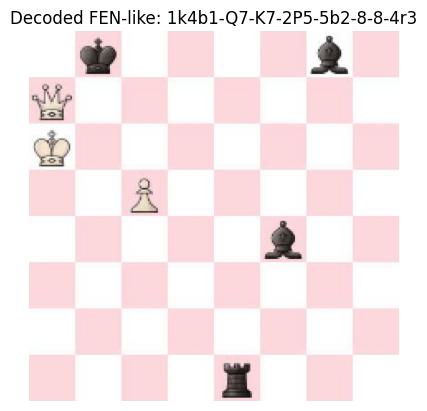

In [9]:
# Cell 8: Visual sanity check

batch_imgs, batch_labels = next(iter(train_ds))
print("Batch images shape:", batch_imgs.shape)      # (B, H, W, 3)
print("Batch labels shape:", batch_labels.shape)    # (B, 64, 13)

def show_sample(idx=0):
    img = batch_imgs[idx].numpy()
    labels_one_hot = batch_labels[idx].numpy()
    labels = labels_one_hot.argmax(axis=-1)
    tokens = labels_to_board_tokens(labels)
    fen_dash = board_tokens_to_fen_with_dashes(tokens)
    
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Decoded FEN-like: {fen_dash}")

show_sample(0)


In [10]:
# Cell 9: Build the model

def build_model(img_size=IMG_SIZE, num_classes=NUM_CLASSES, num_squares=NUM_SQUARES):
    inputs = layers.Input(shape=(img_size, img_size, 3), name="image")

    # CNN backbone
    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights=None,               # set to "imagenet" if you want transfer learning
        input_shape=(img_size, img_size, 3),
        pooling='avg'
    )
    x = base(inputs, training=True)

    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(num_squares * num_classes)(x)
    x = layers.Reshape((num_squares, num_classes))(x)
    outputs = layers.Activation("softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="chess_fen_from_image")
    return model

model = build_model()
model.summary()


Model: "chess_fen_from_image"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 832)            │       426,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 13)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,132,259 (19.58 MB)

 Trainable params: 5,090,236 (19.42 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [11]:
# Cell 10: Compile

loss_fn = tf.keras.losses.CategoricalCrossentropy()
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name="square_accuracy")
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss_fn,
    metrics=metrics
)



In [12]:
# Cell 11: Train

EPOCHS = 1   # adjust as needed / as hardware allows

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_chess_fen_model.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


2025-11-25 00:17:27.634035: I external/local_xla/xla/service/service.cc:163] XLA service 0x75d1c00143d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-25 00:17:27.634061: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-11-25 00:17:28.290513: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-25 00:17:31.436311: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-25 00:17:33.437802: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 00:17:33.

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.9348 - square_accuracy: 0.8127
Epoch 1: val_loss improved from None to 0.71269, saving model to best_chess_fen_model.h5


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 282s 95ms/step - loss: 0.8128 - square_accuracy: 0.8382 - val_loss: 0.7127 - val_square_accuracy: 0.8439 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.


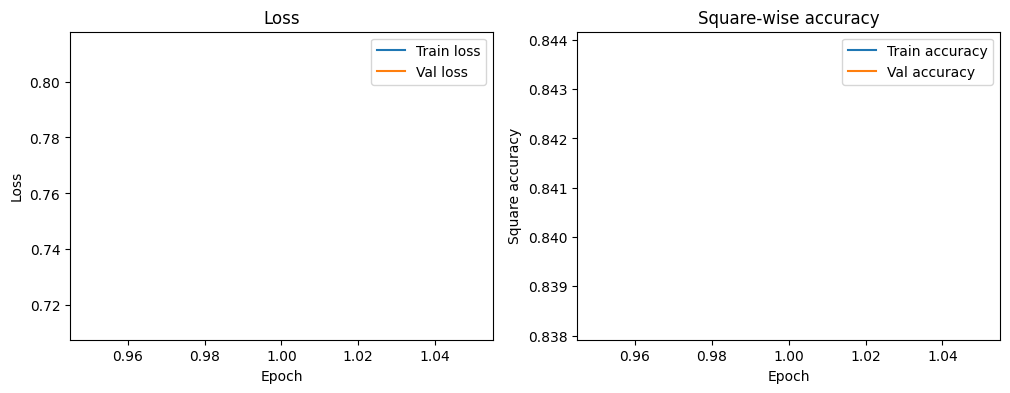

In [13]:
# Cell 12: Plot learning curves

def plot_history(history):
    h = history.history
    epochs_range = range(1, len(h["loss"]) + 1)

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, h["loss"], label="Train loss")
    plt.plot(epochs_range, h["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, h["square_accuracy"], label="Train accuracy")
    plt.plot(epochs_range, h["val_square_accuracy"], label="Val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Square accuracy")
    plt.legend()
    plt.title("Square-wise accuracy")

    plt.show()

plot_history(history)


In [14]:
# Cell 13: Inference utilities

def predict_fen_from_path(model, img_path):
    """
    model: trained Keras model.
    img_path: path to a single image.
    Returns: predicted FEN-like string with dashes.
    """
    img = decode_img(img_path)
    img = tf.expand_dims(img, axis=0)  # (1, H, W, 3)

    preds = model.predict(img)[0]      # (64, 13)
    label_ids = preds.argmax(axis=-1)  # (64,)

    tokens = labels_to_board_tokens(label_ids)
    fen_dash = board_tokens_to_fen_with_dashes(tokens)
    return fen_dash


# evaluate on a few validation examples
sample_val = val_df.sample(5, random_state=SEED)

for _, row in sample_val.iterrows():
    true_fen = row["fen"]
    pred_fen = predict_fen_from_path(model, row["path"])
    print("Image:", row["path"])
    print("True: ", true_fen)
    print("Pred: ", pred_fen)
    print("-" * 60)


2025-11-25 00:21:57.009604: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-25 00:21:57.223647: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-25 00:21:57.871850: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-25 00:21:58.123152: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-25 00:21:58.382984: E external/local_xla/xla/stream_

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Image: /home/kikiman/.cache/kagglehub/datasets/koryakinp/chess-positions/versions/1/train/8-2R2n2-2n3P1-3p4-b7-8-8-2K1b1qk.jpeg
True:  8-2R2n2-2n3P1-3p4-b7-8-8-2K1b1qk
Pred:  8-8-8-8-8-8-8-8
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: /home/kikiman/.cache/kagglehub/datasets/koryakinp/chess-positions/versions/1/train/8-4b1p1-7Q-K6k-8-2N5-8-8.jpeg
True:  8-4b1p1-7Q-K6k-8-2N5-8-8
Pred:  8-8-8-8-8-8-8-8
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: /home/kikiman/.cache/kagglehub/datasets/koryakinp/chess-positions/versions/1/train/8-R1q2N1B-3p4-N7-8-K7-P1k4p-R2r2B1.jpeg
True:  8-R1q2N1B-3p4-N7-8-K7-P1k4p-R2r2B1
Pred:  8-8-8-8-8-8-8-8
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: /home/kikiman/.cache/kagglehub/datasets/koryakinp/chess-positions/versions/1/train/2K2k2-1b6-6p1-

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


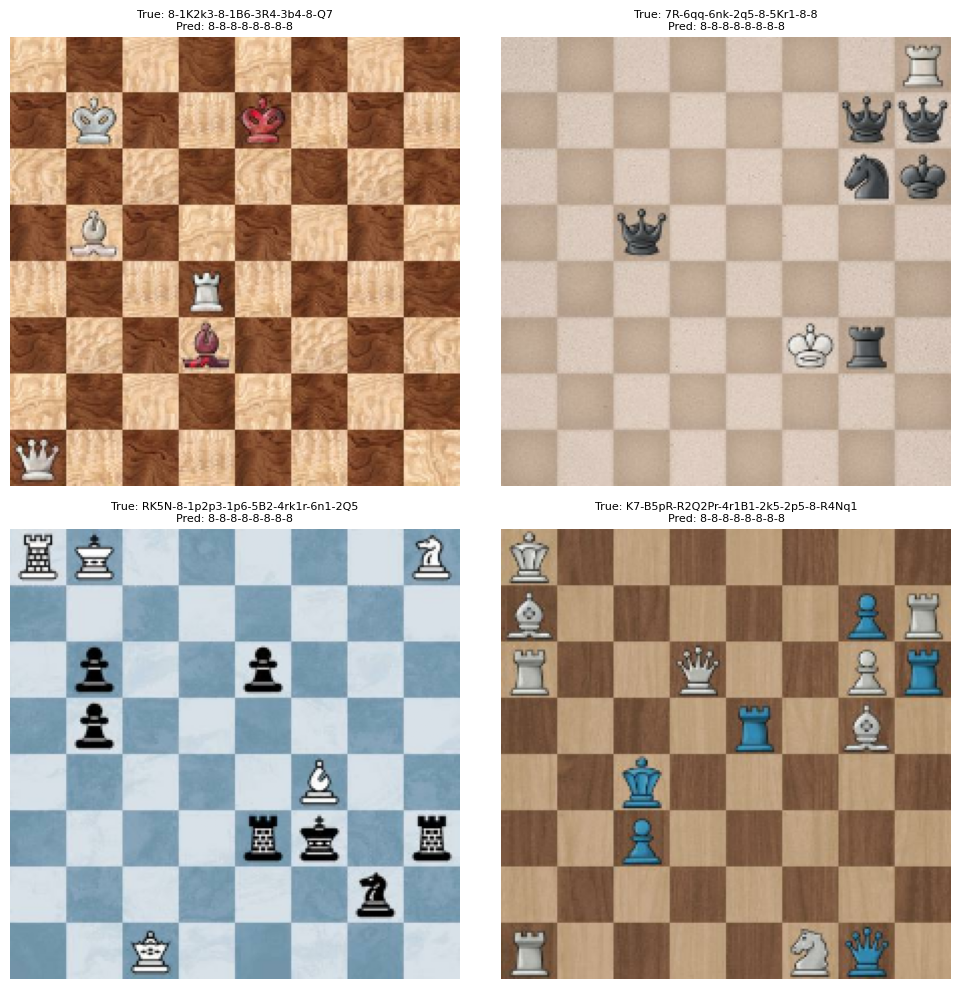

In [15]:
# Cell 14: Show some images with predicted vs true FEN

def show_prediction(idx=0, df_subset=None):
    if df_subset is None:
        df_subset = val_df
    
    row = df_subset.iloc[idx]
    img_path = row["path"]
    true_fen = row["fen"]
    pred_fen = predict_fen_from_path(model, img_path)

    img = decode_img(img_path).numpy()

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {true_fen}\nPred: {pred_fen}", fontsize=8)

# Show 4 samples
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    show_prediction(i)
plt.tight_layout()
plt.show()


In [16]:
# Cell 15: Predict on test set and save to CSV

test_image_paths = sorted(glob.glob(str(TEST_DIR / "*.png"))) + \
                   sorted(glob.glob(str(TEST_DIR / "*.jpg"))) + \
                   sorted(glob.glob(str(TEST_DIR / "*.jpeg")))

print("Found", len(test_image_paths), "test images")

pred_records = []
for p in test_image_paths:
    fen_pred = predict_fen_from_path(model, p)
    pred_records.append({
        "path": p,
        "fen_pred": fen_pred
    })

pred_df = pd.DataFrame(pred_records)
pred_df.head()

# Save (e.g. for Kaggle submission if needed)
pred_df.to_csv("chess_fen_predictions.csv", index=False)


Found 20000 test images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 

In [ ]:
# Cell 16: Save model

model.save("chess_fen_from_image_model")

# Later / in another notebook:
# model = tf.keras.models.load_model("chess_fen_from_image_model")
